# Small Angle X-ray Scattering

Small Angle X-ray Scattering (SAXS) is a reciprocal space technique that can be used to investigate magnetic structures on mesoscopic length scales. It uses the effect of magnetic circular dichroism, in which left and right circularly polarised light are absorbed differently in the presence of a magnetic field parallel to the propagation direction of the light. Due to this effect, only magnetisation parallel the beam direction is able to scatter X-rays. The wavelengths of the X-rays can be tuned to the absorption edges of the different elements present in the sample allowing for element-specific magnetisation to be measured. However, in calculating SAXS from micromagnetic simulations we can use the approximation that the cross sections are non element specific.

The differential scattering cross section can be given by
\begin{equation}
\frac{d\Sigma}{d\Omega} \propto \left\vert \widetilde{M_z} \right\vert^2
\end{equation}
where $\widetilde{M_z}$ is the Fourier transform of the $z$ component of the magnetisation Ref. \[[van der Laan](https://onlinelibrary.wiley.com/iucr/doi/10.1107/S0909049598005019)\].

## SAXS Reference frame

For `mag2exp` the SAXS experimental reference frame is defined with the beam propagating in the $z$ direction.

<img src="Figures/SAXS.png" width="900" height="600">

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-dimensional magnetic structure with periodic boundary conditions in the $xy$ plane.

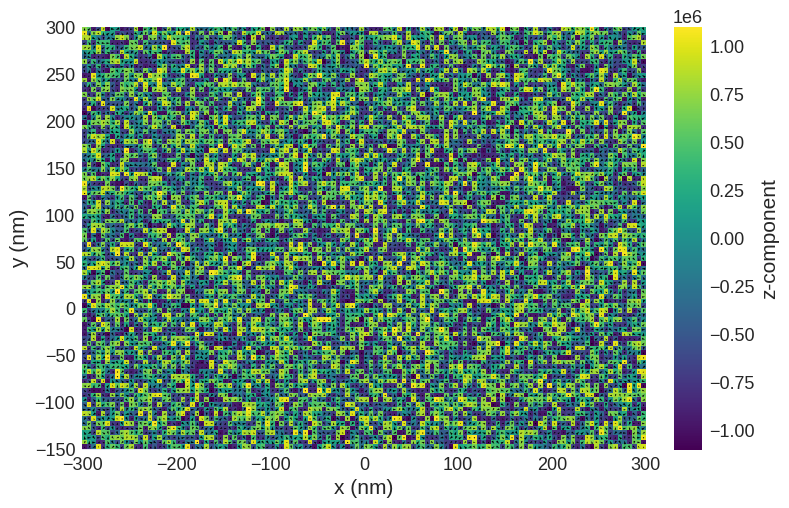

In [1]:
%matplotlib inline
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

np.random.seed(1)

region = df.Region(p1=(-300e-9, -150e-9, 0), p2=(300e-9, 300e-9, 5e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc="xy")

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11) + mm.DMI(D=4e-3, crystalclass="T") + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)
system.m.sel("z").mpl()

Running OOMMF (ExeOOMMFRunner)[2025-06-01T15:36:49]... (54.1 s)


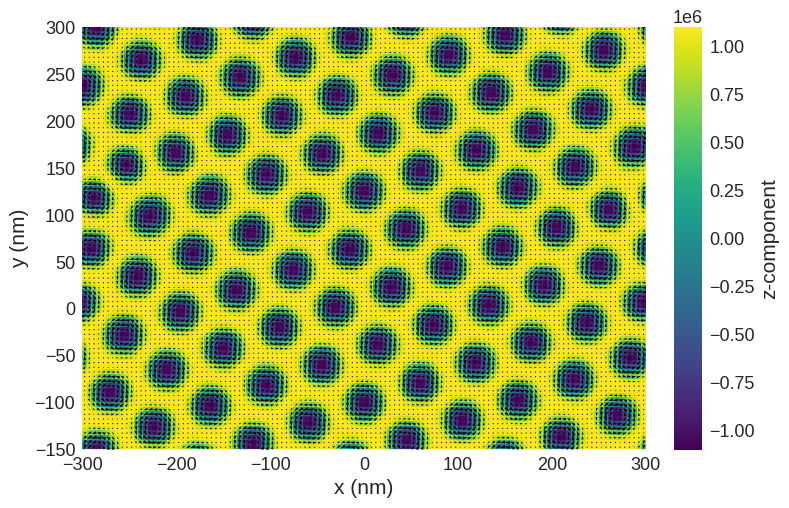

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

Now we have a magnetisation texture we can compute the SAXS scattering cross sections.

## Computing SAXS Cross-sections

We can use the `mag2exp` package to calculate the cross section
\begin{equation}
\frac{d\Sigma}{d\Omega} \propto \left\vert \widetilde{M_z} \right\vert^2 .
\end{equation}

In [3]:
import mag2exp

In [4]:
cross_section = mag2exp.x_ray.saxs(system.m)

As the cross section is a `discretisedfield` object the built-in plotting functions can be used to view them.

NOTE: The values of the axis in Fourier space are frequency NOT angular frequency so DO NOT include a factor of $2\pi$. i.e. $|{\bf k}| = \frac{1}{\lambda} \neq \frac{2 \pi}{\lambda}$, where $\bf k$ is the wave vector and $\lambda$ is the wavelength.

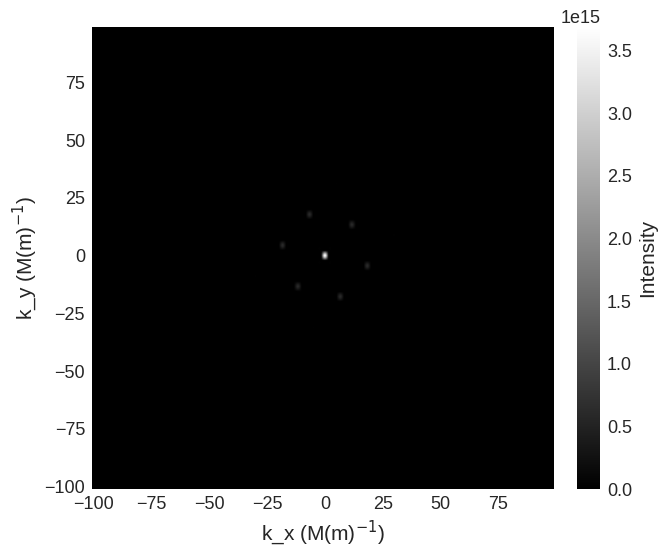

In [5]:
cross_section.mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity"
)

Due to the high intensity of some areas a linear colour map make some features more difficult to see. We can use `matplotlib.color` to change the colour bar to a logarithmic scale. This 
reveals the higher order low intensity diffraction peaks. 

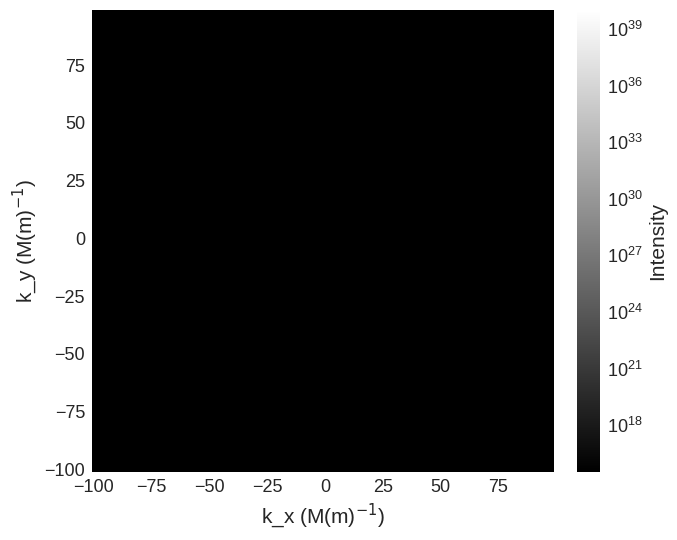

In [6]:
import matplotlib.colors as colors

cross_section.mpl.scalar(
    cmap="gray",
    colorbar_label=r"Intensity",
    norm=colors.LogNorm(vmin=1e40, vmax=cross_section.real.array.max()),
)

It is also possible to just plot a selected region of the cross section by

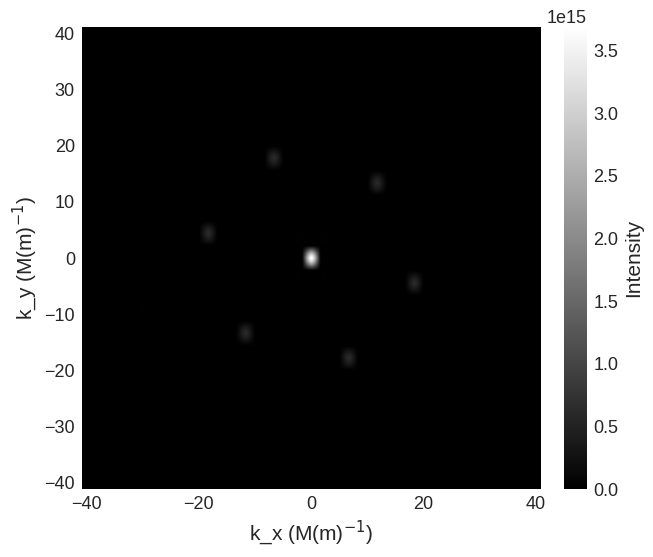

In [7]:
saxs_region = df.Region(p1=(-40e6, -40e6), p2=(40e6, 40e6))
cross_section[saxs_region].mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity"
)